In [1]:
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

2023-12-13 23:04:25.698614: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("We're using TF", tf.__version__)
#print("We are using Keras", tf.keras.__version__)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
    # Visible devices must be set at program startup
        print(e)

# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

#GPU count and name
!nvidia-smi -L

#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

We're using TF 2.13.1


# MNIST

In [3]:
# скачиваем данные
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

# что за данные
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[5 0 4 1 9 2 1 3 1 4]
[7 2 1 0 4 1 4 9 5 9]


Пример кусочка картинки (пиксели со значениями от 0 до 255):


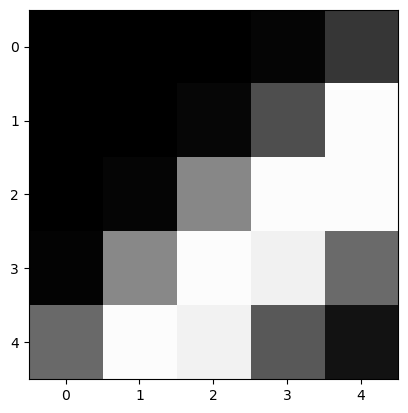

Пример картинки:


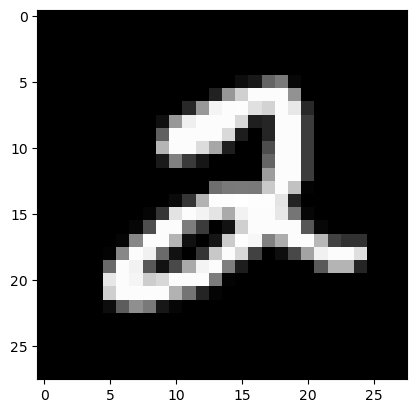

y_train [shape (60000,)] 10 примеров:
 [5 0 4 1 9 2 1 3 1 4]


In [4]:
# нарисуем картинку
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки (пиксели со значениями от 0 до 255):")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")
plt.show()
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])

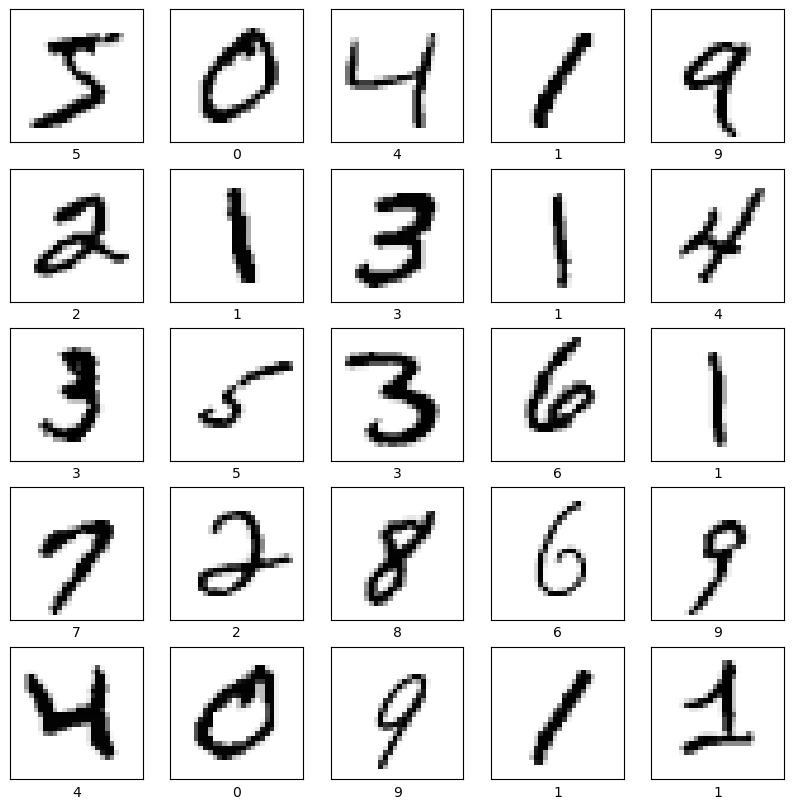

In [5]:
# Посмотрим побольше примеров
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap="Greys")
    plt.xlabel(y_train[i])
plt.show()

In [6]:
# вытянем картинку в вектор размера 28*28=784 и будем использовать это как фичи!

x_train_flat = x_train.reshape(-1, 28*28).astype(float)
print(x_train.shape, x_train_flat.shape)

x_val_flat = x_val.reshape(-1, 28*28).astype(float)
print(x_val.shape, x_val_flat.shape)


# центрируем и нормируем, так сети будет проще учиться
x_train_float = x_train_flat.astype(float) / 255 - 0.5
x_val_float = x_val_flat.astype(float) / 255 - 0.5

# по сути, это действия аналогичны нормализации через StandardScaler
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# x_train_flat = scaler.fit_transform(x_train_flat)
# x_val_flat = scaler.transform(x_val_flat)

# Но попробуйте пропустить нормирование и посмотрите что будет ;)
# x_train_float = x_train_flat.astype(np.float)
# x_val_float = x_val_flat.astype(np.float)

# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

clear_session()

(60000, 28, 28) (60000, 784)
(10000, 28, 28) (10000, 784)
(60000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]] [5 0 4 1 9]


In [7]:
# Архитектура сети
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(x_train_float.shape[1],))) # первый скрытый слой
model.add(Dense(128, activation='relu',)) # второй скрытый слой
model.add(Dense(10, activation='softmax',)) # выходной слой
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235146 (918.54 KB)
Trainable params: 235146 (918.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-12-13 23:04:28.879705: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-13 23:04:28.879735: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: victor-dev
2023-12-13 23:04:28.879740: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: victor-dev
2023-12-13 23:04:28.879819: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 545.23.6
2023-12-13 23:04:28.879837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 545.23.6
2023-12-13 23:04:28.879841: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 545.23.6


In [8]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаем что это :)
    metrics=['accuracy']  # выводим процент правильных ответов
)

history = model.fit(
                    x_train_float,
                    y_train_oh,
                    batch_size=64,  # 64 объекта для подсчета градиента на каждом шаге
                    epochs=10,  # 10 проходов по датасету
                    validation_data=(x_val_float, y_val_oh)
                    )

Epoch 1/10
938/938 [==============================] - 3s 2ms/step - loss: 0.3118 - accuracy: 0.9058 - val_loss: 0.1545 - val_accuracy: 0.9538
Epoch 2/10
938/938 [==============================] - 2s 2ms/step - loss: 0.1411 - accuracy: 0.9570 - val_loss: 0.1110 - val_accuracy: 0.9659
Epoch 3/10
938/938 [==============================] - 2s 2ms/step - loss: 0.1051 - accuracy: 0.9676 - val_loss: 0.1161 - val_accuracy: 0.9668
Epoch 4/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0842 - accuracy: 0.9734 - val_loss: 0.0954 - val_accuracy: 0.9701
Epoch 5/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0710 - accuracy: 0.9769 - val_loss: 0.1064 - val_accuracy: 0.9673
Epoch 6/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0643 - accuracy: 0.9789 - val_loss: 0.0958 - val_accuracy: 0.9709
Epoch 7/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0534 - accuracy: 0.9834 - val_loss: 0.1032 - val_accuracy: 0.9674
Epoch 

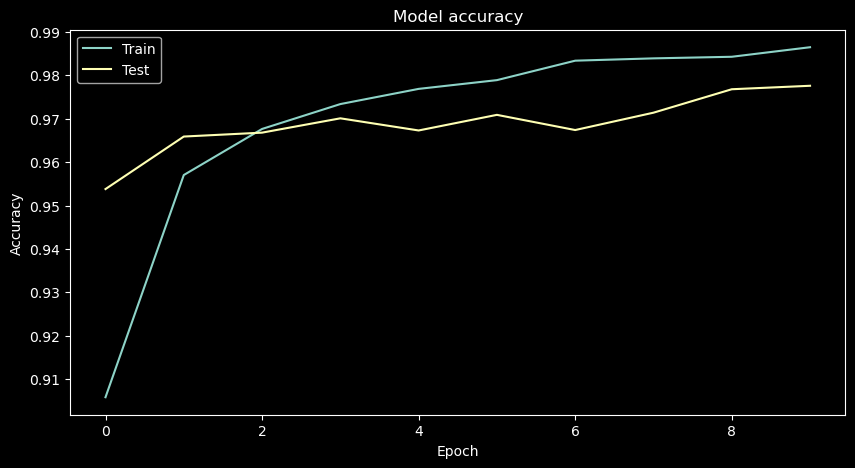

In [14]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

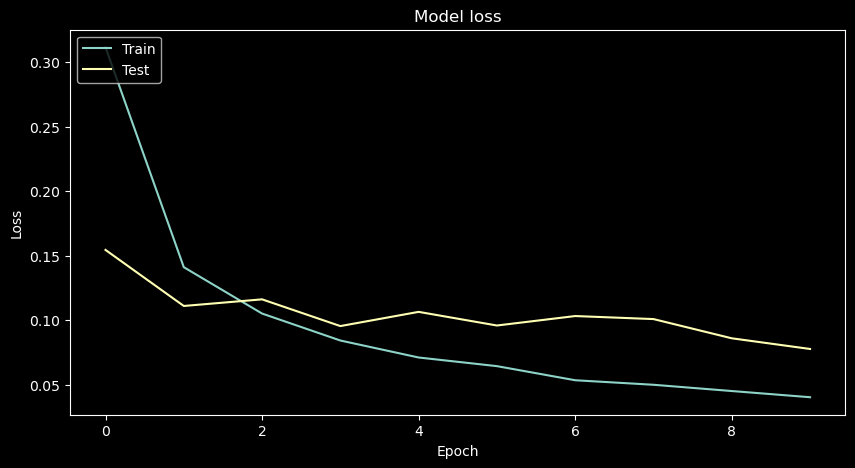

In [15]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
model.predict(x_val_float)

313/313 [==============================] - 0s 680us/step


array([[4.20385771e-09, 8.90219809e-09, 8.37536049e-08, ...,
        9.99989152e-01, 6.91410174e-09, 7.73442753e-06],
       [7.47333011e-12, 9.32850575e-10, 1.00000000e+00, ...,
        1.68630718e-15, 9.26698163e-11, 1.95050698e-18],
       [1.65144968e-07, 9.98821437e-01, 1.37480645e-04, ...,
        2.60953384e-04, 1.78774644e-04, 4.14579290e-07],
       ...,
       [2.47233184e-17, 3.18016121e-13, 3.54691252e-14, ...,
        1.57547775e-09, 1.15274856e-11, 1.40830112e-08],
       [3.08132790e-08, 1.93432336e-12, 1.24220978e-09, ...,
        2.88969133e-08, 7.02297257e-06, 6.81777912e-10],
       [1.76947947e-13, 4.84889601e-14, 1.15272090e-13, ...,
        1.88217246e-16, 3.11233955e-10, 2.49989786e-12]], dtype=float32)

In [23]:
#model.predict_classes(x_val_float)

# аналогично
#np.argmax(model.predict(x_val_float), axis = 1)

#predicts = model.predict_classes(x_val_float)
#print('Test Accuracy: ', accuracy_score(y_val, predicts))

In [27]:
predicts = model.predict(x_val_float) 
classes = np.argmax(predicts, axis=1)

print('Test Accuracy: ', accuracy_score(y_val, classes))

313/313 [==============================] - 0s 685us/step
Test Accuracy:  0.9776
